In [3]:
import gym
import numpy as np

In [4]:
env = gym.make('Blackjack-v1')

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [5]:
for i in range(1):
  state = env.reset()

  while True:
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    print(state, action, reward, next_state)

    if done:
      print('done')
      break
    
    state = next_state

(19, 3, False) 1 -1.0 (22, 3, False)
done


In [6]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import pandas as pd
from collections import namedtuple
from collections import defaultdict
import random
%matplotlib inline

def plot_value_function(V, title='Value Function'):
  # plots the value function as a surface flot.

  min_x = 11 # min(k[0] for k in V.keys())
  max_x = max(k[0] for k in V.keys())
  min_y = min(k[1] for k in V.keys())
  max_y = max(k[1] for k in V.keys())

  x_range = np.arange(min_x, max_x + 1)
  y_range = np.arange(min_y, max_y + 1)
  X, Y = np.meshgrid(x_range, y_range)

  # find value for all (x, y) coordinates
  Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
  Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

  def plot_surface(X, Y, Z, title):
    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot(111, projection = '3d')
    surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()

  plot_surface(X, Y, Z_noace, '{} (No Usable Ace)'.format(title))
  plot_surface(X, Y, Z_ace, '{} (Usable Ace)'.format(title))

In [7]:
def random_policy(observation):
  return env.action_space.sample()

def hit_only_policy(observation):
  if observation[0] == 21:
    return 0
  return 1

def stick_only_policy(observation):
  return 0

# A policy that sticks if the player score is >= X and hits otherwise
def fixed_policy(observation):
  score, dealer_score, usable_ace = observation
  return 0 if score >= 16 else 1

In [8]:
def play_game(policy, env):
  nWon = 0
  nLost = 0
  nDraw = 0
  policy = policy

  for i in range(100000):
    observation = env.reset()
    for i in range(100):
      action = policy(observation)

      next_observation, reward, done, _= env.step(action)
      if done:
        if reward == 1:
          nWon += 1
        elif reward == -1:
          nLost += 1
        else:
          nDraw += 1
        break
      
      observation = next_observation
    
  print(nWon, nLost, nDraw)

In [9]:
play_game(random_policy, env)
play_game(hit_only_policy, env)
play_game(stick_only_policy, env)
play_game(fixed_policy, env)

28265 67535 4200
16070 82157 1773
38286 56798 4916
41657 48826 9517


In [10]:
def mc_prediction(policy, env, num_episodes, alpha=0.01, gamma=0.99):
  N = defaultdict(float)
  V = defaultdict(float)

  for i_episode in range(num_episodes):
    state = env.reset()
    trajectory = []
    while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action)
      trajectory.append((state, action, reward))
      if done:
        break
      state = next_state 

    states, actions, rewards = zip(*trajectory)
    discounts = np.array([gamma**i for i in range(len(rewards))])

    for i, s in enumerate(states):
      N[s] += 1
      G = sum(rewards[i:]*discounts[:len(rewards)-i])
      V[s] = V[s] + 1/N[s] * (G-V[s])

  return V

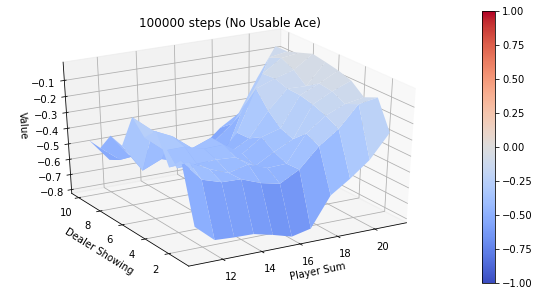

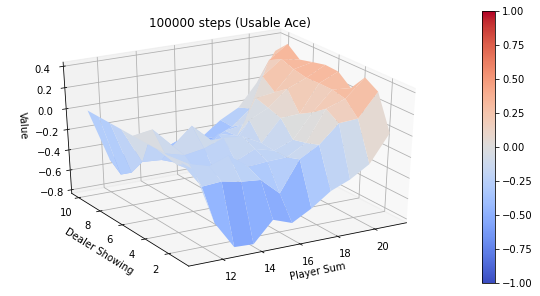

In [11]:
V_random = mc_prediction(random_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

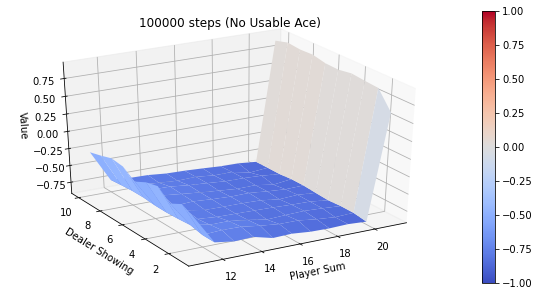

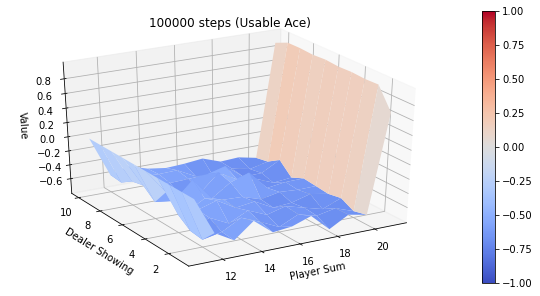

In [12]:
V_random = mc_prediction(hit_only_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

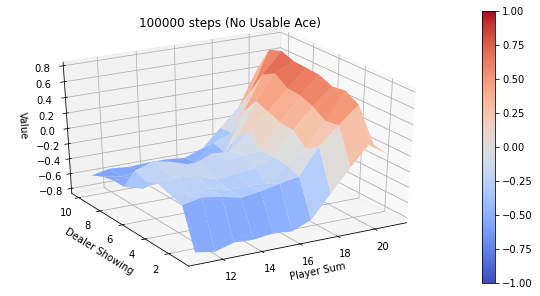

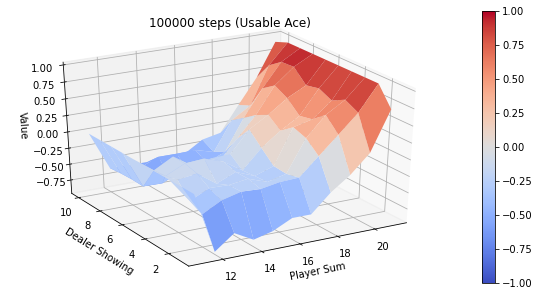

In [13]:
V_random = mc_prediction(stick_only_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

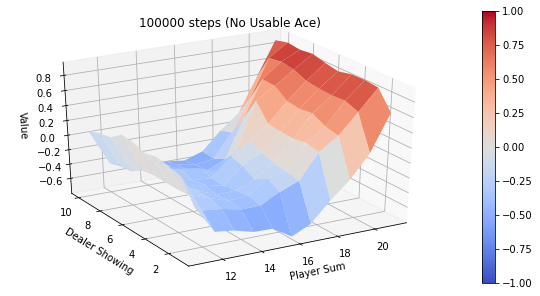

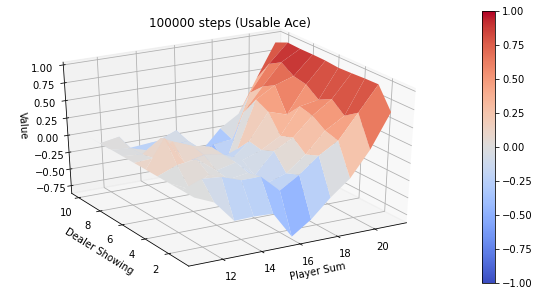

In [14]:
V_random = mc_prediction(fixed_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

In [15]:
def td_prediction(policy, env, num_episodes, alpha=0.01, gamma=0.99):
  N = defaultdict(float)
  V = defaultdict(float)

  for i_episode in range(num_episodes):
    state = env.reset()
    trajectory = []
    while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action)
      V[state] = V[state] + alpha*(reward+gamma*V[next_state] - V[state])
      if done:
        break
      state = next_state

  return V

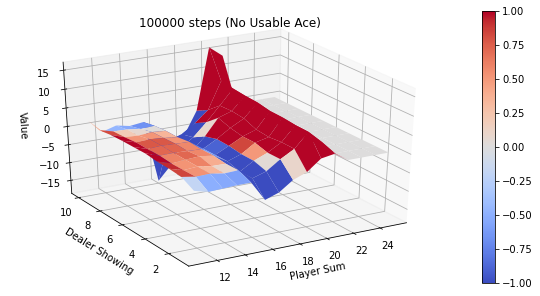

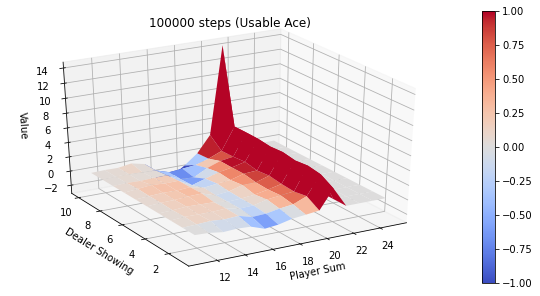

In [16]:
V_random = td_prediction(fixed_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

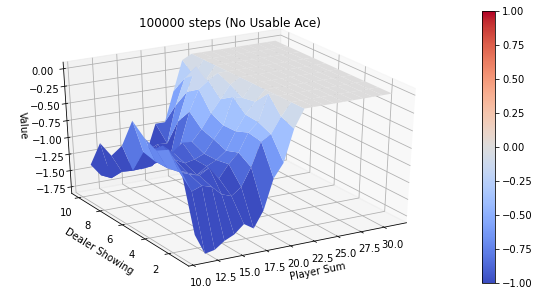

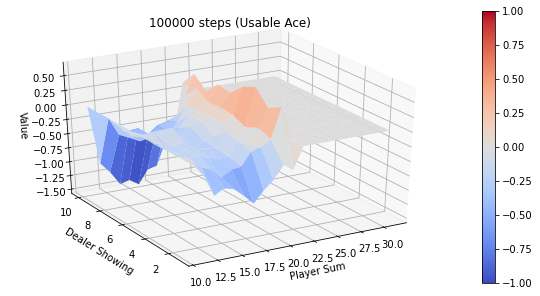

In [17]:
V_random = td_prediction(random_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')

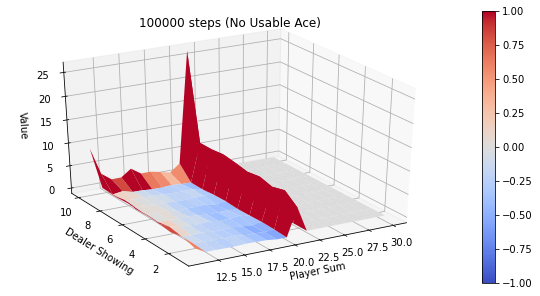

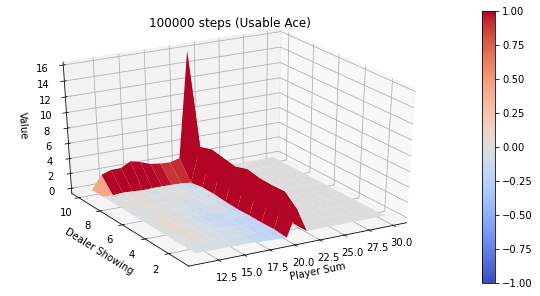

In [18]:
V_random = td_prediction(hit_only_policy, env, num_episodes=100000)
plot_value_function(V_random, title = '100000 steps')